In [1]:
# Imports
## For some arithmetic and Matrix Operations
import numpy as np

## Dataframe Manipulation
import pandas as pd

## For Visualization
import matplotlib.pyplot as plt

## For Visualization too
import seaborn as sns

## For Statistical Analysis
from scipy import stats



# Part 1 - Linear Regression

    Continuting with the same Hypothesis, explainatory variables and sub-class of samples from Project 3 part 1.

For this part we will continue with the Explainatory variables: 
* Gender - Categorial variable.
* Monthly Alcohol Consumption - Continuous variable.
* Monthly Fruit Consumption - Continuous variable.
And the Explained variable:
* BMI - Continuous variable.


**Hypothesis**: How Do Gender, Alcohol consumption and Fruit consumption affect BMI?


    Sampling a 200 sized data for the rest of the question same as in Project 3 part 1

In [2]:
# Load the data
df = pd.read_csv('df_for_proj (1).csv')
# Renaming the 'Sex' column to 'Gender'
df.rename(columns={'Sex':'Gender'}, inplace=True)

# Picking a random sample of 200 rows.
np.random.seed(314)
df_sample_200 = df.sample(200)

    Calculating the coefficients vector of the Linear regression - beta, same as in Project 3 part 1
    

In [3]:
# calculate the coeeficients vector beta for the linear regression model BMI ~ Alcohol Consumption, Fruit Consumption, Sex.

# Split data into features and target
X=df_sample_200[['Alcohol_Consumption','Fruit_Consumption', 'Gender']]
# Adapt the target to the logistic regression
y=df_sample_200['BMI']
# Adding column of ones to the features
X=X.assign(ones=1)

# Convert the data to numpy arrays
X = X.values
y = y.values
y=y.reshape([y.shape[0],]) # Reshape y to 1D array

# Calculate the coefficients vector beta
beta_200 = np.linalg.inv(X.T @ X) @ X.T @ y # b = (X^T * X)^-1 * X^T * y
print(f"The coefficients vector beta for the linear regression model BMI ~ X1:Alcohol Consumption , X2:Fruit Consumption, X3:Gender is: {beta_200}")
print(f'The regression model is: y={beta_200[0]}*X1 + {beta_200[1]}*X2 + {beta_200[2]}*X3 + {beta_200[3]}')



The coefficients vector beta for the linear regression model BMI ~ X1:Alcohol Consumption , X2:Fruit Consumption, X3:Gender is: [-8.57990328e-02 -1.11878202e-02  1.95056386e+00  2.83024281e+01]
The regression model is: y=-0.08579903284792036*X1 + -0.01118782018341976*X2 + 1.950563857302633*X3 + 28.30242808086157


## Part 1
    Calculation the Confidence Intervals for each of the regression coefficients in different methods.

### Part 1.1.A
    Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Covariance matrix of beta.

In [4]:
# Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Covariance matrix of beta.
num_columns = X.shape[1] # Number of columns in the features matrix
# Calculate the residuals
residuals = y - X @ beta_200
# Calculate the variance of the residuals
variance_residuals = np.var(residuals)
# Calculate the covariance matrix of beta
cov_beta = np.linalg.inv(X.T @ X) * variance_residuals # Covariance matrix of beta = (X^T * X)^-1 * variance_residuals
# Calculate the standard errors of the coefficients
df_Error = X.shape[0] - 3 # Degrees of freedom for the Error : n-p. p=3 because we have 3 features.
SE_beta = np.sqrt(np.diag(cov_beta))
# se_alcohol=SE_beta[0] # Standard error of the coefficient for Alcohol Consumption.
# se_fruit=SE_beta[1] # Standard error of the coefficient for Fruit Consumption.
# se_gender=SE_beta[2] # Standard error of the coefficient for Gender.
# se_bias=SE_beta[3] # Standard error of the bias term.
# Calculate the 95% confidence intervals
CI_var_matrix = np.zeros((num_columns,2))
for i in range(num_columns):
    CI_var_matrix[i] = [beta_200[i]-stats.norm.ppf(0.975)*SE_beta[i], beta_200[i]+stats.norm.ppf(0.975)*SE_beta[i]]
print (f"The 95% confidence interval for the coefficient of Alcohol Consumption is: {CI_var_matrix[0]}")
print (f"The 95% confidence interval for the coefficient of Fruit Consumption is: {CI_var_matrix[1]}")
print (f"The 95% confidence interval for the coefficient of Gender is: {CI_var_matrix[2]}")
print (f"The 95% confidence interval for the bias term is: {CI_var_matrix[3]}")


The 95% confidence interval for the coefficient of Alcohol Consumption is: [-0.18749776  0.01589969]
The 95% confidence interval for the coefficient of Fruit Consumption is: [-0.04655383  0.02417819]
The 95% confidence interval for the coefficient of Gender is: [0.25488728 3.64624043]
The 95% confidence interval for the bias term is: [26.61533362 29.98952254]


### Part 1.1.B
    Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Bootsrap method.

In [5]:
# Building a function to calculate the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Bootsrap method.
def normal_aprox_bootstrap(X, y, num_bootstraps):
    """
    Perform normal approximation bootstrap for linear regression.

    Parameters:
    X (numpy.ndarray): The independent variable matrix of shape (n, p), where n is the number of observations and p is the number of features.
    y (numpy.ndarray): The dependent variable vector of shape (n,).
    num_bootstraps (int): The number of bootstrap samples to generate.

    Returns:
    tuple: A tuple containing the confidence intervals and standard errors of the coefficients.
        - CI_boot_mean (numpy.ndarray): The confidence intervals for each coefficient based on the normal distribution approximation. Vector of shape (p, 2), where p is the number of features.
        - SE_boot_mean (numpy.ndarray): The standard errors of the coefficients. vector of shape (p,).

    """
    # Number of observations
    n = X.shape[0]
    # Number of features
    num_columns = X.shape[1] # Size of the columns of X.
    # Initialize the matrix of coefficients
    beta_boot = np.zeros((num_bootstraps, num_columns))
    # Initialize the matrix of residuals
    residuals_boot = np.zeros((num_bootstraps, n))
    # Initialize the matrix of standard errors
    SE_boot = np.zeros((num_bootstraps, num_columns))
    # Initialize the matrix of confidence intervals
    CI_boot = np.zeros((num_bootstraps, num_columns, 2))
    # Loop over the bootstrap samples
    for b in range(num_bootstraps):
        # Generate the bootstrap sample
        index_boot = np.random.choice(n, n, replace=True) # Generate a random sample of n observations with replacement.
        X_boot = X[index_boot, :]
        y_boot = y[index_boot]
        # Calculate the coefficients vector beta
        beta_boot[b, :] = np.linalg.inv(X_boot.T @ X_boot) @ X_boot.T @ y_boot
        # Calculate the residuals
        residuals_boot[b, :] = y_boot - X_boot @ beta_boot[b, :]
        # Calculate the variance of the residuals
        variance_residuals_boot = np.var(residuals_boot[b, :])
        # Calculate the covariance matrix of beta
        cov_beta_boot = np.linalg.inv(X_boot.T @ X_boot) * variance_residuals_boot
        # Calculate the standard errors of the coefficients
        SE_boot[b, :] = np.sqrt(np.diag(cov_beta_boot))
        # Calculate the 95% confidence intervals
        df_Error_boot = X_boot.shape[0] - X_boot.shape[1]
        CI_boot[b, :, 0] = beta_boot[b, :] - stats.norm.ppf(0.975) * SE_boot[b, :]
        CI_boot[b, :, 1] = beta_boot[b, :] + stats.norm.ppf(0.975) * SE_boot[b, :]
    # Calculate the average of the coefficients
    beta_boot_mean = np.mean(beta_boot, axis=0)
    # Calculate the standard errors of the coefficients
    SE_boot_mean = np.std(beta_boot, axis=0)
    # Calculate the 95% confidence intervals for each coefficient based on the normal distribution approximation.
    CI_boot_mean = np.zeros((num_columns, 2))
    for i in range(num_columns):
        CI_boot_mean[i, 0] = beta_boot_mean[i] - stats.norm.ppf(0.975) * SE_boot_mean[i]
        CI_boot_mean[i, 1] = beta_boot_mean[i] + stats.norm.ppf(0.975) * SE_boot_mean[i]
    return CI_boot_mean, SE_boot_mean


In [6]:
B = 400
CI_boot_mean, _ = normal_aprox_bootstrap(X, y, B) # CI_boot_mean is the CI based on the Bootstrap method.
print (f"The 95% confidence interval for the coefficient of Alcohol Consumption is: {CI_boot_mean[0]}")
print (f"The 95% confidence interval for the coefficient of Fruit Consumption is: {CI_boot_mean[1]}")
print (f"The 95% confidence interval for the coefficient of Gender is: {CI_boot_mean[2]}")
print (f"The 95% confidence interval for the bias term is: {CI_boot_mean[3]}")


The 95% confidence interval for the coefficient of Alcohol Consumption is: [-0.16534069 -0.01214201]
The 95% confidence interval for the coefficient of Fruit Consumption is: [-0.04698808  0.02552639]
The 95% confidence interval for the coefficient of Gender is: [0.13013547 3.74396468]
The 95% confidence interval for the bias term is: [26.31553562 30.32012216]


### Part 1.1.C
    Calculating the Confidence Intervals based on the Bootstrap method when the estimator for SE is based on the Pivot method.

In [7]:
# Calculating the Confidence Intervals based on the Bootstrap method when the estimator for SE is based on the Pivot method.
# Build CI using pivotal method bootstrap
n = X.shape[0]
beta_boot=np.zeros((B,num_columns))
residuals_boot=np.zeros((B,n))
SE_boot=np.zeros((B,num_columns))

for b in range(B):
    index_boot=np.random.choice(n,n,replace=True)
    X_boot=X[index_boot,:]
    y_boot=y[index_boot]
    beta_boot[b,:]=np.linalg.inv(X_boot.T @ X_boot) @ X_boot.T @ y_boot # b = (X^T * X)^-1 * X^T * y
    residuals_boot[b,:]=y_boot - X_boot @ beta_boot[b,:]
    variance_residuals_boot = np.var(residuals_boot[b,:])
    cov_beta_boot = np.linalg.inv(X_boot.T @ X_boot) * variance_residuals_boot
    SE_boot[b,:]=np.sqrt(np.diag(cov_beta_boot))

CI_boot_pivotal=np.zeros((num_columns,2))
for i in range(num_columns):
    CI_boot_pivotal[i,0]=2*beta_200[i]-np.quantile(beta_boot[:,i],0.975) # CI = 2*beta - quantile(0.975) of the bootstrap distribution (lower bound)
    CI_boot_pivotal[i,1]=2*beta_200[i]-np.quantile(beta_boot[:,i],0.025) # CI = 2*beta - quantile(0.025) of the bootstrap distribution (upper bound)
print(f"The 95% confidence interval for the coefficient of Alcohol Consumption is: {CI_boot_pivotal[0]}")
print(f"The 95% confidence interval for the coefficient of Fruit Consumption is: {CI_boot_pivotal[1]}")
print(f"The 95% confidence interval for the coefficient of gender is: {CI_boot_pivotal[2]}")
print(f"The 95% confidence interval for the bias term is: {CI_boot_pivotal[3]}")


The 95% confidence interval for the coefficient of Alcohol Consumption is: [-0.16272462 -0.01251756]
The 95% confidence interval for the coefficient of Fruit Consumption is: [-0.04391255  0.02492651]
The 95% confidence interval for the coefficient of gender is: [0.18689827 3.59058614]
The 95% confidence interval for the bias term is: [26.38405073 30.27758649]


### Part 1.1.D
    Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Quantiles method.

In [8]:
# Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Quantiles method.
# Build CI using quantiles method bootstrap
CI_boot_quantiles=np.zeros((num_columns,2))
for i in range(num_columns):
    CI_boot_quantiles[i,0]=np.quantile(beta_boot[:,i],0.025) # Lower bound
    CI_boot_quantiles[i,1]=np.quantile(beta_boot[:,i],0.975) # Upper bound
print(f"The 95% confidence interval for the coefficient of Alcohol Consumption is: {CI_boot_quantiles[0]}")
print(f"The 95% confidence interval for the coefficient of Fruit Consumption is: {CI_boot_quantiles[1]}")
print(f"The 95% confidence interval for the coefficient of Gender is: {CI_boot_quantiles[2]}")
print(f"The 95% confidence interval for the bias term is: {CI_boot_quantiles[3]}")



The 95% confidence interval for the coefficient of Alcohol Consumption is: [-0.1590805  -0.00887344]
The 95% confidence interval for the coefficient of Fruit Consumption is: [-0.04730215  0.02153691]
The 95% confidence interval for the coefficient of Gender is: [0.31054157 3.71422944]
The 95% confidence interval for the bias term is: [26.32726967 30.22080544]


## Part 1.2
    Calculating the Confidence Intervals based on the Normal Distribution approximation when the estimator for SE is based on the Quantiles method. For each method we'll check whether the true beta is in the CI or not.

In [9]:
# Calculate the coefficients vector beta for the linear regression model based on the full data.
df_all = df
# Split data into features and target
X=df_all[['Alcohol_Consumption','Fruit_Consumption', 'Gender']]
# Adapt the target to the logistic regression
y=df_all['BMI']
# Adding column of ones to the features
X=X.assign(ones=1)

# Convert the data to numpy arrays
X = X.values
y = y.values
y=y.reshape([y.shape[0],]) # Reshape y to 1D array

# Calculate the coefficients vector beta
beta_all = np.linalg.inv(X.T @ X) @ X.T @ y # b = (X^T * X)^-1 * X^T * y



In [10]:
# A boolean function to recognize if the coefficient estimation is in the CI
def is_in_CI(CI, beta):
    """
    This function checks if the coefficient estimation is in the confidence interval.
    
    :param CI: A list of the confidence interval.
    :param beta: The coefficient estimation.
    :return: A boolean value.
    """
    return CI[0] <= beta <= CI[1]

In [11]:
# Building a function to print if the beta estimator of the full data is in the CI of the 200 sized df calculated by the different methods.
def print_in_CI(CI, beta, method):
    """
    This function prints if the beta estimator of the full data is in the confidence interval of the 200 sized df calculated by the different methods.
    
    :param CI: A list of the confidence interval.
    :param beta: The coefficient estimation.
    :param method: The method used to calculate the confidence interval.
    """
    for i in range(len(beta)):
        if is_in_CI(CI[i], beta[i]):
            print(f"The coefficient estimation beta_{(i+1)%4} IS in the confidence interval calculated by the {method} method.")
        else:
            print(f"The coefficient estimation beta_{(i+1)%4} IS NOT in the confidence interval calculated by the {method} method.")
            
    

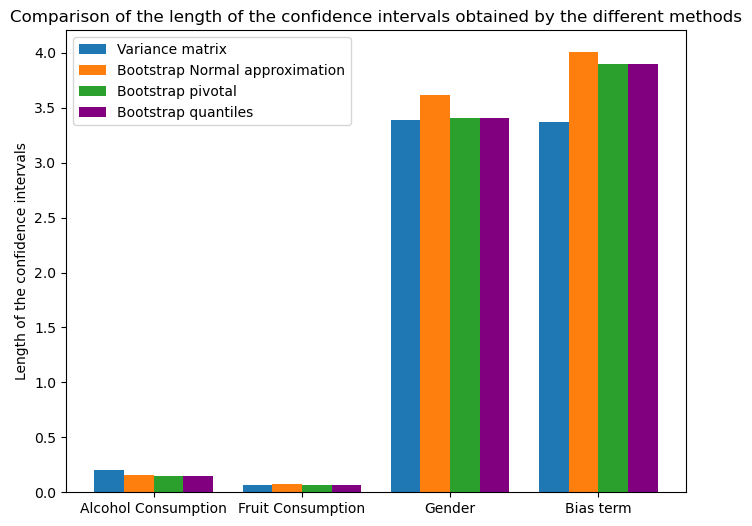

Variance matrix method:
The coefficient estimation beta_1 IS in the confidence interval calculated by the Variance matrix method.
The coefficient estimation beta_2 IS in the confidence interval calculated by the Variance matrix method.
The coefficient estimation beta_3 IS NOT in the confidence interval calculated by the Variance matrix method.
The coefficient estimation beta_0 IS in the confidence interval calculated by the Variance matrix method.

Bootstrap Normal approximation method:
The coefficient estimation beta_1 IS in the confidence interval calculated by the Bootstrap Normal approximation method.
The coefficient estimation beta_2 IS in the confidence interval calculated by the Bootstrap Normal approximation method.
The coefficient estimation beta_3 IS in the confidence interval calculated by the Bootstrap Normal approximation method.
The coefficient estimation beta_0 IS in the confidence interval calculated by the Bootstrap Normal approximation method.

Bootstrap pivotal metho

In [37]:
# Comparing the confidence intervals length obtained by the different methods.
# Calculate the length of the confidence intervals
CI_length_var_matrix = CI_var_matrix[:,1] - CI_var_matrix[:,0]
CI_length_boot_mean = CI_boot_mean[:,1] - CI_boot_mean[:,0]
CI_length_boot_pivotal = CI_boot_pivotal[:,1] - CI_boot_pivotal[:,0]
CI_length_boot_quantiles = CI_boot_quantiles[:,1] - CI_boot_quantiles[:,0]
# Plot the length of the confidence intervals on the same graph with a bar plot
plt.figure(figsize=(8,6))
plt.bar(np.arange(num_columns), CI_length_var_matrix, width=0.2, label='Variance matrix')
plt.bar(np.arange(num_columns)+0.2, CI_length_boot_mean, width=0.2, label='Bootstrap Normal approximation')
plt.bar(np.arange(num_columns)+0.4, CI_length_boot_pivotal, width=0.2, label='Bootstrap pivotal')
plt.bar(np.arange(num_columns)+0.6, CI_length_boot_quantiles, color='purple', width=0.2, label='Bootstrap quantiles')
plt.xticks(np.arange(num_columns)+0.3, ['Alcohol Consumption', 'Fruit Consumption', 'Gender', 'Bias term'])
plt.ylabel('Length of the confidence intervals')
plt.legend()
plt.title('Comparison of the length of the confidence intervals obtained by the different methods')
plt.show()

# Check if the coefficient estimation is in the confidence intervals for the different methods and the different coefficients. 
print('Variance matrix method:')
print_in_CI(CI_var_matrix, beta_all, 'Variance matrix')
print()
print('Bootstrap Normal approximation method:')
print_in_CI(CI_boot_mean, beta_all, 'Bootstrap Normal approximation')
print()
print('Bootstrap pivotal method:')
print_in_CI(CI_boot_pivotal, beta_all, 'Bootstrap pivotal')
print()
print('Bootstrap quantiles method:')
print_in_CI(CI_boot_quantiles, beta_all, 'Bootstrap quantiles')


As we can see by the lengths comparison, the lengths of the CI according to the 'Pivotal' and 'Quantiles' methods are fairly the same for the Explainatory variables and the bias term, while the length according to the 'Variance matrix' method is different for Alcohol consumption and the same for the two other Explainatory variables. The biggest difference in lengths is seen in the Bias term, where the length according to the 'Variance matrix' method is the shortest and the two other methods gave the same lengths somewhere in between the two. the CI based on the 'Bootstrap Normal approximation' changes based on the different picks of indices for the bootstrap sampling.

## Part 1.3
    Working on a new set of 100 samples that are not from the 200 existing samples

### Part 1.3.A   
    Predicting the point's value given X_new

In [13]:
sampled_indices = df_sample_200.index
reduced_df = df_all.drop(sampled_indices) # get rid of the 200 samples we've worked with until now for this df.
#sample 100 from the reduced data
np.random.seed(314)
df_sample_new_100 = reduced_df.sample(100) # sample 100 from the reduced data.
df_sample_new_100.head()

,Unnamed: 0,Heart_Disease,Gender,Depression,BMI,FriedPotato_Consumption,Alcohol_Consumption,Fruit_Consumption
173569,173569,0,0,0,39.48,1.0,0.0,30.0
10290,10290,0,1,1,27.37,4.0,0.0,5.0
113204,113204,1,0,1,30.13,12.0,0.0,4.0
116379,116379,0,1,0,26.39,1.0,8.0,8.0
282397,282397,0,0,0,21.97,4.0,0.0,30.0


In [14]:
# predicting the y values for the new data by applying the coefficients vector beta on given X values
X_new = df_sample_new_100[['Alcohol_Consumption', 'Fruit_Consumption', 'Gender']].assign(ones=1).values
y_new_real = df_sample_new_100['BMI'].values
y_new_pred = X_new @ beta_200

### Part 1.3.B+C    
    Calculating the confidence intervals for Y_new using the Bootstrap method and checking the appearance percentage

In [15]:
# Calculating the confidence intervals for Y_new using the Bootstrap method and checking the appearance percentage. 
# Using the Normal approximation Bootstrap method to calculate the confidence intervals for Y_new
B=400
n=100

# Initialize the matrix of predictions
y_new_pred_boot=np.zeros((B,n))
# Initialize the matrix of residuals
residuals_new_boot=np.zeros((B,n))
# Initialize the matrix of standard errors
SE_new_boot=np.zeros((B,n))
# Initialize the matrix of confidence intervals
CI_new_boot=np.zeros((B,n,2))
# Loop over the bootstrap samples
for b in range(B):
    # Generate the bootstrap sample
    index_boot=np.random.choice(n,n,replace=True) # Generate a random sample of n observations with replacement.
    X_boot=X_new[index_boot,:]
    y_boot=y_new_pred[index_boot]
    # Calculate the predictions
    y_new_pred_boot[b,:]=X_boot @ beta_200
    # Calculate the residuals
    residuals_new_boot[b,:]=y_boot - y_new_pred_boot[b,:]
    # Calculate the variance of the residuals
    variance_residuals_new_boot = np.var(residuals_new_boot[b,:])
    # Calculate the standard errors of the predictions
    SE_new_boot[b,:]=np.sqrt(variance_residuals_new_boot)
    # Calculate the 95% confidence intervals
    df_Error_new_boot = X_boot.shape[0] - X_boot.shape[1]
    CI_new_boot[b,:,0]=y_new_pred_boot[b,:]-stats.norm.ppf(0.975)*SE_new_boot[b,:]
    CI_new_boot[b,:,1]=y_new_pred_boot[b,:]+stats.norm.ppf(0.975)*SE_new_boot[b,:]
# Calculate the average of the predictions
y_new_pred_boot_mean=np.mean(y_new_pred_boot,axis=0)
# Calculate the standard errors of the predictions
SE_new_boot_mean=np.std(y_new_pred_boot,axis=0)
# Calculate the 95% confidence intervals for each prediction based on the normal distribution approximation.
CI_new_boot_mean=np.zeros((n,2))
for i in range(n):
    CI_new_boot_mean[i,0]=y_new_pred_boot_mean[i]-stats.norm.ppf(0.975)*SE_new_boot_mean[i]
    CI_new_boot_mean[i,1]=y_new_pred_boot_mean[i]+stats.norm.ppf(0.975)*SE_new_boot_mean[i]
# Calculate the percentage of times the true value of y is in the confidence interval
percentage_in_CI=np.mean((CI_new_boot_mean[:,0]<=y_new_real) & (y_new_real<=CI_new_boot_mean[:,1]))

print(f"The percentage of times the true value is in the confidence interval is: {percentage_in_CI*100}%")




The percentage of times the true value is in the confidence interval is: 28.999999999999996%


As we can see, the percenrage is far from 95%. This outcome makes sense since we calculated the CI for E[Yi_new|Xi_new] and not for the prediction Yi_pred itself, so that the calculations did not depend on the variance of Y_new.
The meaning of the result is that in 95% of cases, the value of E[Yi_new|Xi_new] will be contained inside the Confidence Interval but not necessarily the value of Y_new itself.

### Part 1.3.D
    Discussing the calculations of Y_new's CI instead of it's Expectation based on Bootstrap
    

In the case of calculating the CI for Y_new itself, the variance consists of another component - the variance of the noise - $\epsilon$ which is missing from the calcluations of the CI for E[Yi_new|Xi_new].
So when calculating the CI for Y_new, we will calculate the S.E for the Bootstrap samples and in addition, the S.E for the noise $\epsilon$

## Part 2
    Tests

### Part 2.1
    Writing the Hypothesis

**The Hypothesis for this part:** Is the Distribution of alcohol consumption within people who are considered to be suffering from depression Stochastically bigger than the Distribution alcohol consumption within people who are not?

### Part 2.2
    Sampling a 200 sized data to work with

In [16]:
# Load the data
df_all = pd.read_csv('df_for_proj (1).csv')

# Picking a random sample of 200 rows.
np.random.seed(314)
df_sample_200_2 = df_all.sample(200)
df_sample_200_2.head()




,Unnamed: 0,Heart_Disease,Sex,Depression,BMI,FriedPotato_Consumption,Alcohol_Consumption,Fruit_Consumption
143684,143684,0,0,0,19.20,4.0,0.0,30.0
18803,18803,0,0,0,24.75,0.0,28.0,60.0
244431,244431,0,0,1,47.77,1.0,0.0,20.0
120543,120543,0,0,0,28.19,2.0,0.0,16.0
142511,142511,0,1,0,37.30,3.0,10.0,4.0


    Plots to check if the data is distributed with a Normal distributions (for parts 3.A and 4.A)

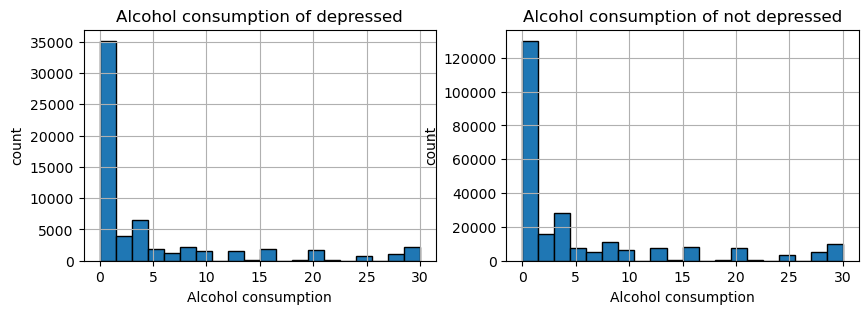

In [17]:
import matplotlib.pyplot as plt
df_depressed = df_all[df_all['Depression']==1]
fig,(ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
df_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax1)
ax1.set_title("Alcohol consumption of depressed")
ax1.set_xlabel("Alcohol consumption")
ax1.set_ylabel("count")

df_not_Depressed = df_all[df_all['Depression']==0]
df_not_Depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax2)
ax2.set_title("Alcohol consumption of not depressed")
ax2.set_xlabel("Alcohol consumption")
ax2.set_ylabel("count")
plt.show()

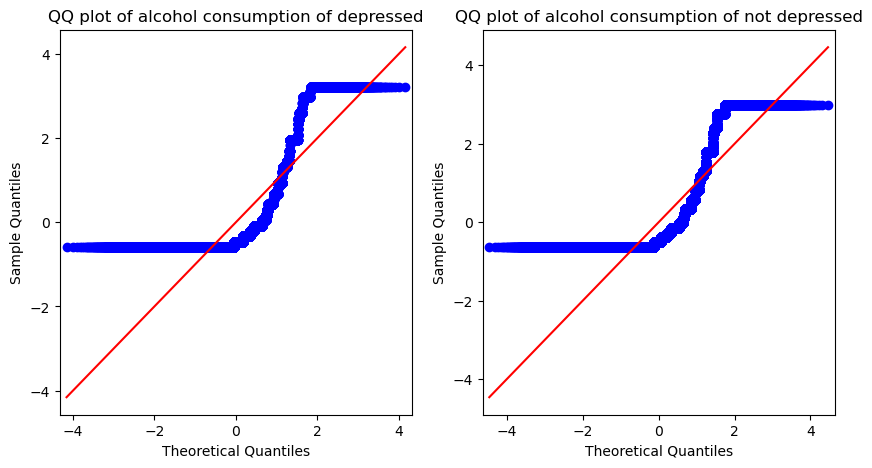

In [39]:
from statsmodels.graphics.gofplots import qqplot
# Lines to ignore warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', 'marker is redundantly defined.*', UserWarning)

# QQ-plot of Alcohol Consumption of Depressed and Not Depressed to fit a Normal distribution on the full data.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
qqplot(df_depressed['Alcohol_Consumption'].values,fit=True, line='s', ax=ax[0])
ax[0].set_title("QQ plot of alcohol consumption of depressed")
qqplot(df_not_Depressed['Alcohol_Consumption'].values ,fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of alcohol consumption of not depressed")
plt.show()


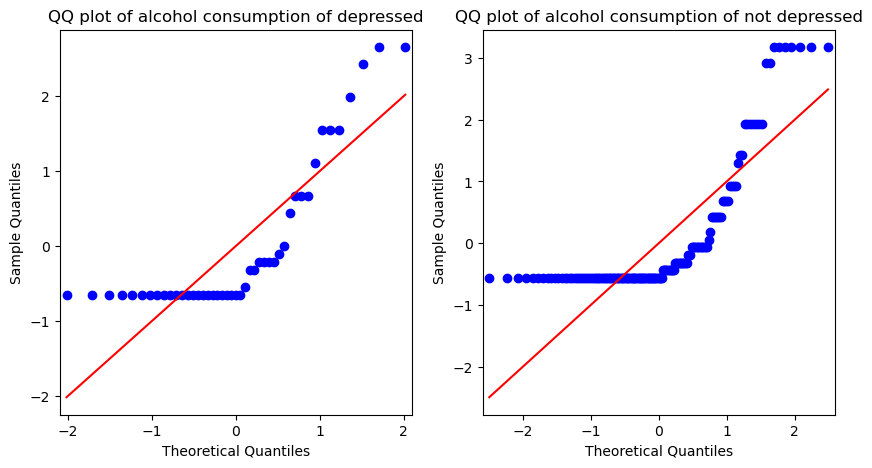

In [40]:
df_sample_depressed= df_sample_200_2[df_sample_200_2['Depression']==1]
df_sample_not_depressed= df_sample_200_2[df_sample_200_2['Depression']==0] 

# QQ-plot of Alcohol consumption of depressed and not depressed for normal distribution on the 200 size sampled data.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
qqplot(df_sample_depressed['Alcohol_Consumption'].values,fit=True, line='s', ax=ax[0])
ax[0].set_title("QQ plot of alcohol consumption of depressed")
qqplot(df_sample_not_depressed['Alcohol_Consumption'].values ,fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of alcohol consumption of not depressed")
plt.show()

### Part 2.3
    Defining the expectations of the variables for each category
    

* $\mu_1$ : The expectation of Alcohol consumption within the depressed people.
* $\mu_2$ : The expectation of Alcohol consumption within the not-depressed people.

#### Part 2.3.A
    Estimating the expectations and the difference between them

In [20]:
# Estimating mu_1, mu_2 and delta = mu_1 - mu_2
# Split the data into two groups

mu_1= np.mean(df_sample_depressed['Alcohol_Consumption'])
mu_2= np.mean(df_sample_not_depressed['Alcohol_Consumption'])
print(f"The estimated mean of Alcohol consumption for the depressed group is: {mu_1}")
print(f"The estimated mean of Alcohol consumption for the not depressed group is: {mu_2}")
delta = mu_1 - mu_2 
print(f"The estimated difference between the means of Alcohol consumption for the depressed and not depressed groups is: {delta}")



The estimated mean of Alcohol consumption for the depressed group is: 5.955555555555556
The estimated mean of Alcohol consumption for the not depressed group is: 4.529032258064516
The estimated difference between the means of Alcohol consumption for the depressed and not depressed groups is: 1.4265232974910393


The data does not come from a Normal distribution - we can see that it comes from an A-symmetric distribution with a lond right tail and from the QQ- plots for a Normal distribution for both datasets. (With reference to the plots in the previous clause) If it were a Normal distribution then the Means would have been MLEs for each of the distributions and then the difference would also be an MLE from a theorem. But since the distribuiton is most likely not a Normal distribution, the condition does not hold, thus the mean is not an MLE, making the difference of means not an MLE either.

#### Part 2.3.B
   

calculating CI to $\delta$

In [21]:
# Calculate conffidence interval to delta
# Calculate the residuals
sample_var_depressed = df_sample_depressed['Alcohol_Consumption'].var(ddof=0)
sample_var_not_depressed = df_sample_not_depressed['Alcohol_Consumption'].var(ddof=0)

quantile = stats.norm.ppf(0.975)
num_depressed=len(df_sample_depressed)
num_not_depressed =len(df_sample_not_depressed)
SE = np.sqrt(sample_var_depressed/num_depressed + sample_var_not_depressed/num_not_depressed)
CI_delta = [delta - quantile*SE, delta + quantile*SE]
print(f"The 95% confidence interval for the difference between the means of Alcohol consumption for the depressed and not depressed groups is: {CI_delta}")

The 95% confidence interval for the difference between the means of Alcohol consumption for the depressed and not depressed groups is: [-1.5077988412099246, 4.360845436192003]


#### Part 2.3.C
    


Esimating $\delta$ based on the full dataset

In [22]:
mu_1_all= np.mean(df_depressed['Alcohol_Consumption'])
mu_2_all= np.mean(df_not_Depressed['Alcohol_Consumption'])
delta_all = mu_1_all - mu_2_all
# is delta_all in the CI above
print(f"Is delta_all in the confidence interval calculated for delta sampled? {CI_delta[0] <= delta_all <= CI_delta[1]}")


Is delta_all in the confidence interval calculated for delta sampled? True


#### Part 2.3.D
    Testing part A hypothesis using Wald and Permutation-tests for one sided hypothesis.

    Wald test:
 

 $H_0: \delta = 0 $

$H_1: \delta > 0 $

$T.S.: W = \frac{(\delta - \delta_0)}{\hat{s.e}}$

$R.R.: |W| > z_{\alpha/2}$ </br>

In [23]:
# Calculate the Wald statistic
Wald = delta/SE
p_value = 1-stats.norm.cdf(Wald)
print(f"The p-value of the Wald test is: {p_value}")
print(f"Reject H0, the null hypothesis?  {Wald> quantile}")


The p-value of the Wald test is: 0.1703360227991778
Reject H0, the null hypothesis?  False


    Permutation test based on Means difference:

 $H_0: F_X = F_Y $

$H_1: F_X \prec F_Y $

$T.S.: \hat{Y_n}-\hat{X_m} $ 

$p-value: \frac{I(T_j \geq T_0)}{\binom{N}{n}}$

$R.R.: p-value < \alpha$ </br>

In [24]:
# Permutation test based on the difference between the means of Alcohol consumption for the depressed and not depressed groups.
import random
num_depressed = df_sample_depressed.shape[0]
num_total_samples = df_sample_200_2.shape[0]
counter = 0 # For the T.S
B=400
# Run simulations
for b in range(B):
    group_1_indices = random.sample(range(num_total_samples), num_depressed)
    group_2_indices =[i for i in range(num_total_samples) if i not in group_1_indices]
    group_1_alcohol = df_sample_200_2.iloc[group_1_indices]['Alcohol_Consumption']
    group_2_alcohol = df_sample_200_2.iloc[group_2_indices]['Alcohol_Consumption']
   
    mu_1_permutation = np.mean(group_1_alcohol)
    mu_2_permutation = np.mean(group_2_alcohol)
    delta_permutation = mu_1_permutation - mu_2_permutation
    if delta_permutation >= delta:
        counter += 1
p_value_permutation = counter / B # Note that in the case of simulations, the T.S becomes an average over B.
print(f"The p-value of the permutation test is: {p_value_permutation}")
print(f"Reject H0, the null hypothesis?  {p_value_permutation < 0.05}")


The p-value of the permutation test is: 0.185
Reject H0, the null hypothesis?  False


### Part 2.4
    Defining the Medians of the variables for each category

#### Part 2.4.A
    

calculating CI to $\delta$

In [25]:
m_1= np.median(df_sample_depressed['Alcohol_Consumption'])
m_2= np.median(df_sample_not_depressed['Alcohol_Consumption'])
delta_median = m_1 -m_2
print(f"The estimated median of Alcohol consumption for the depressed group is: {m_1}")
print(f"The estimated median of Alcohol consumption for the not depressed group is: {m_2}")
print(f"The estimated difference between the medians of Alcohol consumption for the depressed and not depressed groups is: {delta_median}")

The estimated median of Alcohol consumption for the depressed group is: 0.0
The estimated median of Alcohol consumption for the not depressed group is: 0.0
The estimated difference between the medians of Alcohol consumption for the depressed and not depressed groups is: 0.0


As we have mentioned before, the distribution of Alcohol consumption against depressed and not depressed is not a Normal distribution, so we cannot assume that the Median for each distribution is an MLE, thus making the difference of Medians not an MLE either. (The comparison to the graphs is with reference to the plots in the beggining of part 2)

#### Part 2.4.B

Esimating $\delta$ based on the full dataset

In [26]:
#CI for the delta_median
CI_delta = [delta_median - quantile*SE, delta_median + quantile*SE]
print(f"The 95% confidence interval for the difference between the medians of Alcohol consumption for the depressed and not depressed groups is: {CI_delta}")

The 95% confidence interval for the difference between the medians of Alcohol consumption for the depressed and not depressed groups is: [-2.934322138700964, 2.934322138700964]


#### Part 2.4.C

Esimating $\delta$ based on the full dataset

In [27]:
m_1_all = np.median(df_depressed['Alcohol_Consumption'])
m_2_all = np.median(df_not_Depressed['Alcohol_Consumption'])
delta_median_all = m_1_all - m_2_all
# Checking if delta_all is in the CI above.
print(f"Is delta_all in the confidence interval calculated for delta sampled? {CI_delta[0] <= delta_median_all <= CI_delta[1]}")


Is delta_all in the confidence interval calculated for delta sampled? True


#### Part 2.4.D
    Testing part A's hypothesis using a Permutation test.

    Permutation test based on Medians difference:
    

 $H_0: F_X = F_Y $

$H_1: F_X \prec F_Y $

$T.S.: M_y - Mx $ 

$p-value: \frac{I(T_j \geq T_0)}{\binom{N}{n}}$

$R.R.: p-value < \alpha$ </br>

In [28]:
# Permutation test based on the difference between the medians of Alcohol consumption for the depressed and not depressed groups.
num_depressed = df_sample_depressed.shape[0] # Number of depressed people in the sample
num_total_samples = df_sample_200_2.shape[0] # Number of people in the sample
counter = 0 # for the T.S
B = 400
# Run simulations.
for b in range(B):
    group_1_indices = random.sample(range(num_total_samples), num_depressed)
    group_2_indices =[i for i in range(num_total_samples) if i not in group_1_indices]
    group_1_alcohol = df_sample_200_2.iloc[group_1_indices]['Alcohol_Consumption']
    group_2_alcohol = df_sample_200_2.iloc[group_2_indices]['Alcohol_Consumption']
    m_1_permutation = np.median(group_1_alcohol)
    m_2_permutation = np.median(group_2_alcohol)
    delta_permutation = m_1_permutation - m_2_permutation
    if delta_permutation >= delta_median:
        counter += 1
p_value_permutation = counter / B # Note that in the case of simulations, the T.S becomes an average over B.
print(f"The p-value of the permutation test is: {p_value_permutation}")
print(f"Reject H0, the null hypothesis?  {p_value_permutation < 0.05}")


The p-value of the permutation test is: 0.9125
Reject H0, the null hypothesis?  False


#### Part 2.4.E
    Checking if Wald and T-test assumptions for part 2.4.D hold.

    T-test assumptions:

**1.Normal Distribution of the data:**
 We can see from the histogram plots is part 2.2 that the distribution is **not** normal. Just by from already we can say that not all the assumptions for T-test hold.


**2.Equal Variances:**
we will use the F test to check the if the sample variances are equal:
<br>
$𝐻_0: 𝜎_𝑋
^2 = 𝜎_𝑌
^2$

$𝐻_1: 𝜎_𝑋
^2 ≠ 𝜎_𝑌
^2
$

𝑇. 𝑆. : $𝐹$ =
$𝑆_𝑋
^2/
𝑆_𝑌
^2 $∼$F_(n-1,m-1)$


𝑅. 𝑅. : $𝐹$ > $𝐹_(𝑛−1,𝑚−1)$

In [29]:
import scipy.stats as stats

sample_var_not_depressed = df_sample_not_depressed['Alcohol_Consumption'].var(ddof=0) # Variance of the Alcohol consumption for the not depressed group
sample_var_depressed = df_sample_depressed['Alcohol_Consumption'].var(ddof=0) # Variance of the Alcohol consumption for the depressed group
n_not_Depressed = len(df_sample_not_depressed)
n_Depressed = len(df_sample_depressed)

F_stat_test= sample_var_not_depressed/sample_var_depressed
F_p_value= 1-stats.f.cdf(F_stat_test,n_not_Depressed-1,n_Depressed-1)
F_test_quantile= stats.f.ppf(0.95,n_not_Depressed-1,n_Depressed-1)

print("F statistic for test is:"+ str(F_stat_test))
print("F test quantile: " + str(F_test_quantile))
print("P value: " +  str(F_p_value))
print("is in Rejection zone? "  + str(F_stat_test>F_test_quantile))

F statistic for test is:0.785572361418038
F test quantile: 1.5324716967038685
P value: 0.8558793738953656
is in Rejection zone? False


We can see by the F_test that the variances of Alcohol consumption of depressed aginst Alcohol consumption of not depressed pepole are equal based on a F-test on the 200 sized data.

<br>**3.Size of the data:** This assumption holds. our dataset is bigger than 30 querries.
<br>**4.Independent Variables:** Another condition for using the T-test is independent variables.

Since we saw that 1 of the 4 assumptions for the T-test does not hold, there is no need to continue checking.
<br>To conclude, the assumptions for using the T-test **do not hold**.

    Wald-test assumptions:

Since the estimator for the Medians difference is not an MLE, its not Asimptotically normal, so we can't use a Wald test in this case.

### Part 2.5
    Defining the ranks and applying a Permutation test to check Part A's hypothesis.



    Permutation test based on ranks:

 $H_0: F_X = F_Y $

$H_1: F_X \prec F_Y $

$T.S.: \sum_{i=1}^{n} S_i $ 

$p-value: \frac{I(T_j \geq T_0)}{\binom{N}{n}}$

$R.R.: p-value < \alpha$ </br>

In [30]:
# Rank by alcohol consumption using a tie breaker method.
# In case of a tie between ranks, take the middle rank.
df_sample_200_2['Alcohol_cons_rank'] = df_sample_200_2['Alcohol_Consumption'].rank(method='average') # Rank the Alcohol consumption values. In case of a tie, break it like we've seen in class.
S1 = df_sample_200_2[df_sample_200_2['Depression']==1]['Alcohol_cons_rank'].sum() # Sum of ranks for the depressed group

B = 400  
counter = 0

# Permutation test based on the sum of ranks of Alcohol consumption for the depressed group.
# Run simulations.
for b in range(B):
    # Shuffle the depression labels
    group_1_indices = random.sample(range(num_total_samples), num_depressed)
    s1_permutation = df_sample_200_2['Alcohol_cons_rank'].values[group_1_indices].sum()
    if s1_permutation >= S1:
        counter += 1

p_value_permutation = counter / B # Note that in the case of simulations, the T.S becomes an average over B.
print(f"The sum of the ranks of Alcohol consumption for the depressed group is: {S1}")
print(f"The p-value of the permutation test is: {p_value_permutation}")
print(f"Reject H0, the null hypothesis? {p_value_permutation < 0.05}")


The sum of the ranks of Alcohol consumption for the depressed group is: 4686.0
The p-value of the permutation test is: 0.275
Reject H0, the null hypothesis? False


 Using normal approximation: N = 200 > 30 and also all the values are continuous because we used a tie breaker (no ties so no binary values), thus we can use a Normal approximation


In [31]:
# Using the Normal approximation to test the Hypothesis.
N = num_depressed + num_not_depressed  
n =num_depressed
m = num_not_depressed
print(f"n = {n}, m = {m}, N = {N}")
expected = n*(N+1)/2
var = n*m*(N+1)/12
Z = (S1 - expected)/np.sqrt(var)
print(f"Reject H0, the null hypothesis?  {Z >= stats.norm.ppf(0.95)}")

n = 45, m = 155, N = 200
Reject H0, the null hypothesis?  False


As we can see, in all the methods - By simulations and by the Wald test, we are not rejecting the Null hypothesis, so there is a Stochastic equivalance in the distribution of Alcohol Consumption for each catagory.

### Part 2.6
    Discussing the outcomes of parts 3-5.


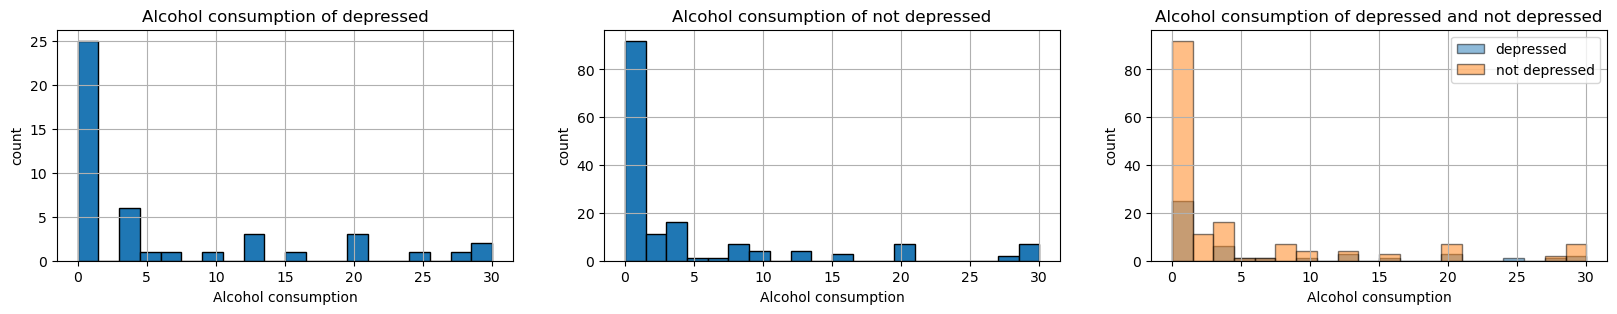

In [32]:
import matplotlib.pyplot as plt

fig,(ax1, ax2 ,ax3)= plt.subplots(1,3,figsize=(20,3))
df_sample_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax1)
ax1.set_title("Alcohol consumption of depressed")
ax1.set_xlabel("Alcohol consumption")
ax1.set_ylabel("count")


df_sample_not_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax2)
ax2.set_title("Alcohol consumption of not depressed")
ax2.set_xlabel("Alcohol consumption")
ax2.set_ylabel("count")


df_sample_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax3, alpha=0.5, label='depressed')
df_sample_not_depressed['Alcohol_Consumption'].hist(edgecolor='black', grid=True, bins=20, ax=ax3, alpha=0.5, label='not depressed')
ax3.set_title("Alcohol consumption of depressed and not depressed")
ax3.set_xlabel("Alcohol consumption")
ax3.set_ylabel("count")
plt.legend()
plt.show()

In all of the permutation tests we ran we rejected the Null hypothesis, thus assuming that the Distributions are Stochatically equal.
Those conclusions sit with the histograms, because as we can see, the ratio between the distribution is kept the same, so we we can assume that the Distributions are proportional. There's a strong possibility that we got these results because we didn't work with enough samples (only 200) in refference to the entire dataset (over 300,000) or didn't do enough repetitons when we simulated the data (only B=400 simulations).
